In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu


## constants and functions

In [2]:

PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_200_CLUS = '../data_out/cluster200.nc'

LA = 'lat'
LO = 'lon'
TI = 'time'
AG = 'age'
AT = 'AIRTRACER'
L = 'lab'
CM = 'tab20'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

COLS = [SA, MSA, IA]
LCOLS = [LSA, LMSA, LIA]

DATA_OUT = '../data_out'

COL = plt.get_cmap('Dark2')

DC = {
    SA  : COL(0),
    MSA : COL(1),
    IA  : COL(2),
    LSA : COL(0),
    LMSA: COL(1),
    LIA : COL(2),
}

In [3]:
df = pd.read_csv(PATH_TO_ST, index_col=0, parse_dates=True)

for l, c in zip(COLS, LCOLS):
    df[c] = np.log10(df[l])

# distributions


lets find what kind of dist. do we have. They seem to be log dists.

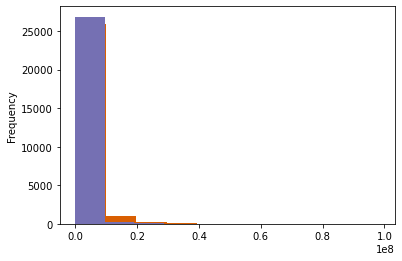

In [4]:
for c in COLS:
    df[c].plot.hist(color=DC[c])

Text(0.5, 0, 'log10')

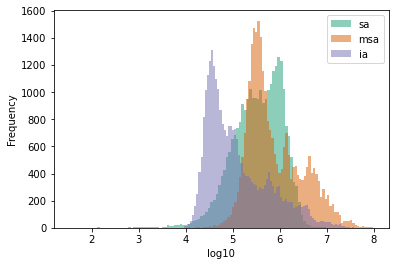

In [5]:
for c in COLS:
    np.log10(df[c]).plot.hist(alpha=.5, bins=100, label=c, color=DC[c])
ax = plt.gca()
ax.legend()
ax.set_xlabel('log10')

# timeseries of the trace gases

# open and merge flex 200 clusters

In [6]:
ds = xr.open_dataset(PATH_200_CLUS)

In [7]:
dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

q0, q1 = np.quantile(dsf.values.flatten(), [.01, .99])



# f, axs = plt.subplots(10, 20, sharex=True, sharey=True, figsize=(20, 20))
# axf = axs.flatten()

# for i, ax in zip(dsf.columns, axf):
#     ax.hist(np.log10(dsf[i] + q0), bins=np.linspace(np.log10(q0), np.log10(q1 + q0), 20))
#     ax.set_xlabel('')
#     ax.set_ylabel('')

In [8]:
dsfn = dsf / dsf.mean()

In [9]:
q0, q1 = dsfn.stack().quantile([.01, .99])

In [10]:
# f, axs = plt.subplots(10, 20, sharex=True, sharey=True, figsize=(20, 20))
# axf = axs.flatten()

# for i, ax in zip(dsfn.columns, axf):
#     ax.hist(dsfn[i], bins=np.linspace(q0, q1, 20))
#     ax.set_xlabel('')
#     ax.set_ylabel('')

In [11]:
df1 = df

In [12]:
df2 = df1.resample('3H').median()

In [13]:
dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")

# Invers modeling elastic NET

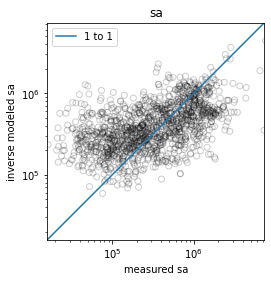

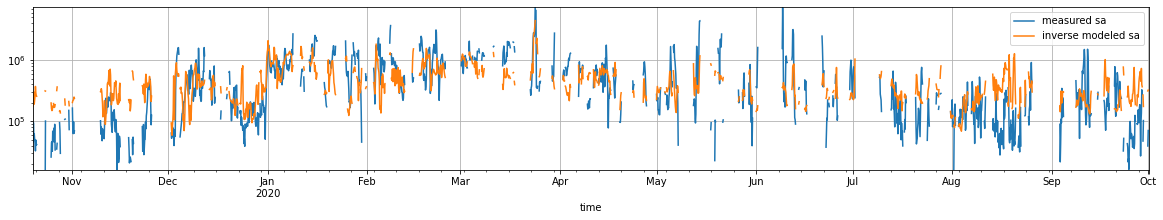

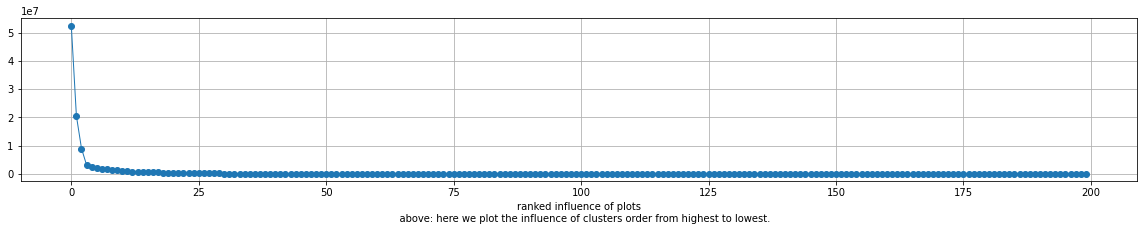

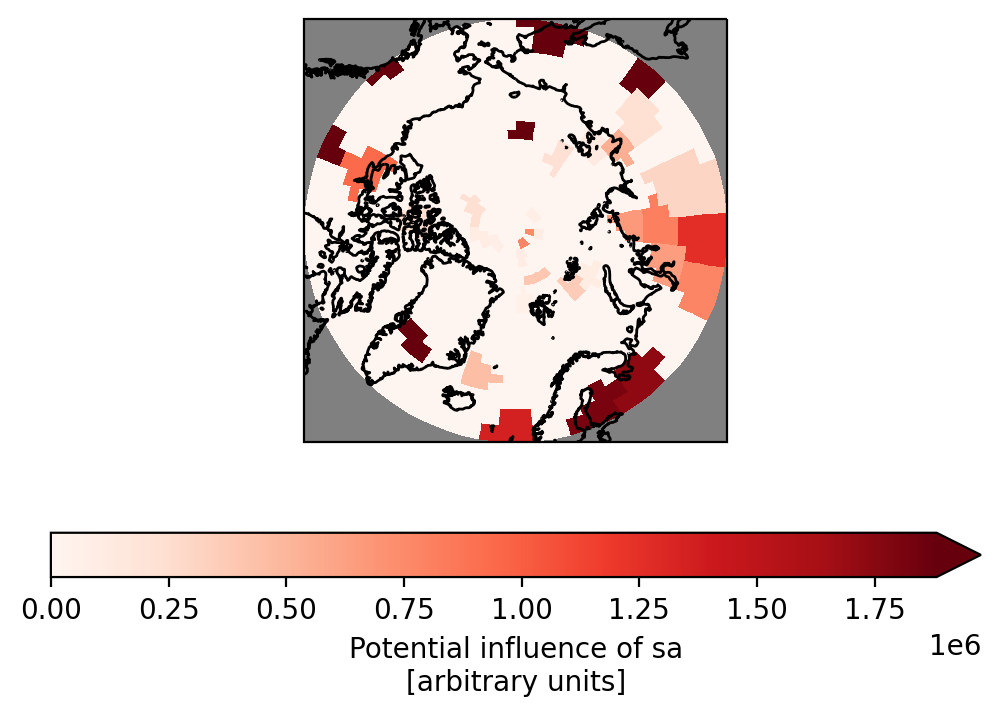

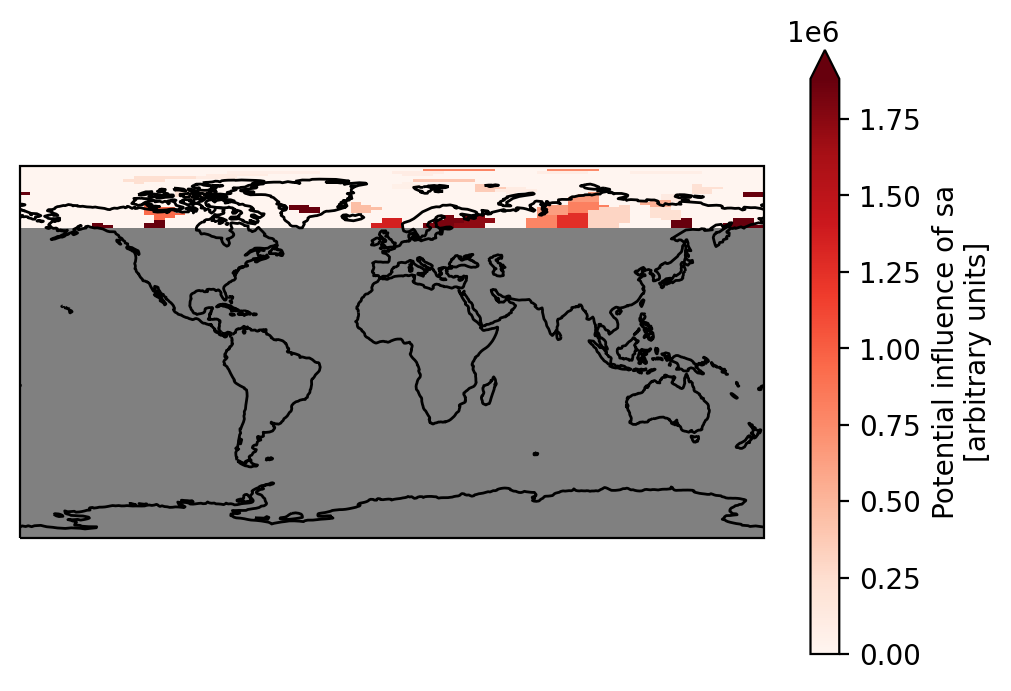

In [14]:
# for PAR in [SA,MSA,IA]:
for PAR in [SA]:
    pred, cdf, y, yn, dp = rfu.elastic_net_reg(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds,PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)

In [15]:
cdf.sort_values(ascending=False)

lab
199    52654256.0
196    20544958.0
181     8979031.0
132     3098593.5
180     2535800.5
          ...    
81            0.0
82            0.0
84            0.0
85            0.0
0             0.0
Length: 200, dtype: float32

In [16]:
import funs as fu

In [17]:
d5 = fu.get_bounds(LA, ds[AT])
d6 = fu.get_bounds(LO, d5)

df = d6[L].to_dataframe()

df1 = df.loc[:, ~df.columns.duplicated()]

G = 'geometry'

In [18]:
df1[G] = df.apply(fu.get_pol, axis=1)

In [19]:
import geopandas
dg = geopandas.GeoDataFrame(df1).reset_index()

dg1 = dg[[L, G]].dissolve(by=L)

In [20]:
cdf.name = 'infl'

In [21]:
df2 = pd.merge(dg1,cdf,left_index=True,right_index=True)

In [22]:
df3 = df2.sort_values('infl',ascending=False).iloc[:20]

In [23]:
df3['infl']

lab
199    5.265426e+07
196    2.054496e+07
181    8.979031e+06
132    3.098594e+06
180    2.535800e+06
168    1.881621e+06
173    1.812176e+06
159    1.730788e+06
162    1.352591e+06
86     1.257938e+06
136    9.339772e+05
105    8.134232e+05
131    7.817694e+05
42     7.806414e+05
31     7.485286e+05
100    6.634729e+05
141    6.443596e+05
109    5.435959e+05
129    4.531878e+05
14     3.943123e+05
Name: infl, dtype: float32

In [24]:
dm1 = dm[df3.index]

In [25]:
dm2 = dm1/dm1.sum()
dm2 = (dm1 * df3['infl'])/100000

In [26]:
cmap = plt.get_cmap('tab20')

In [27]:
co = dm2.columns

In [28]:
q1,q2=dm2.stack().quantile([.001,.999])

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


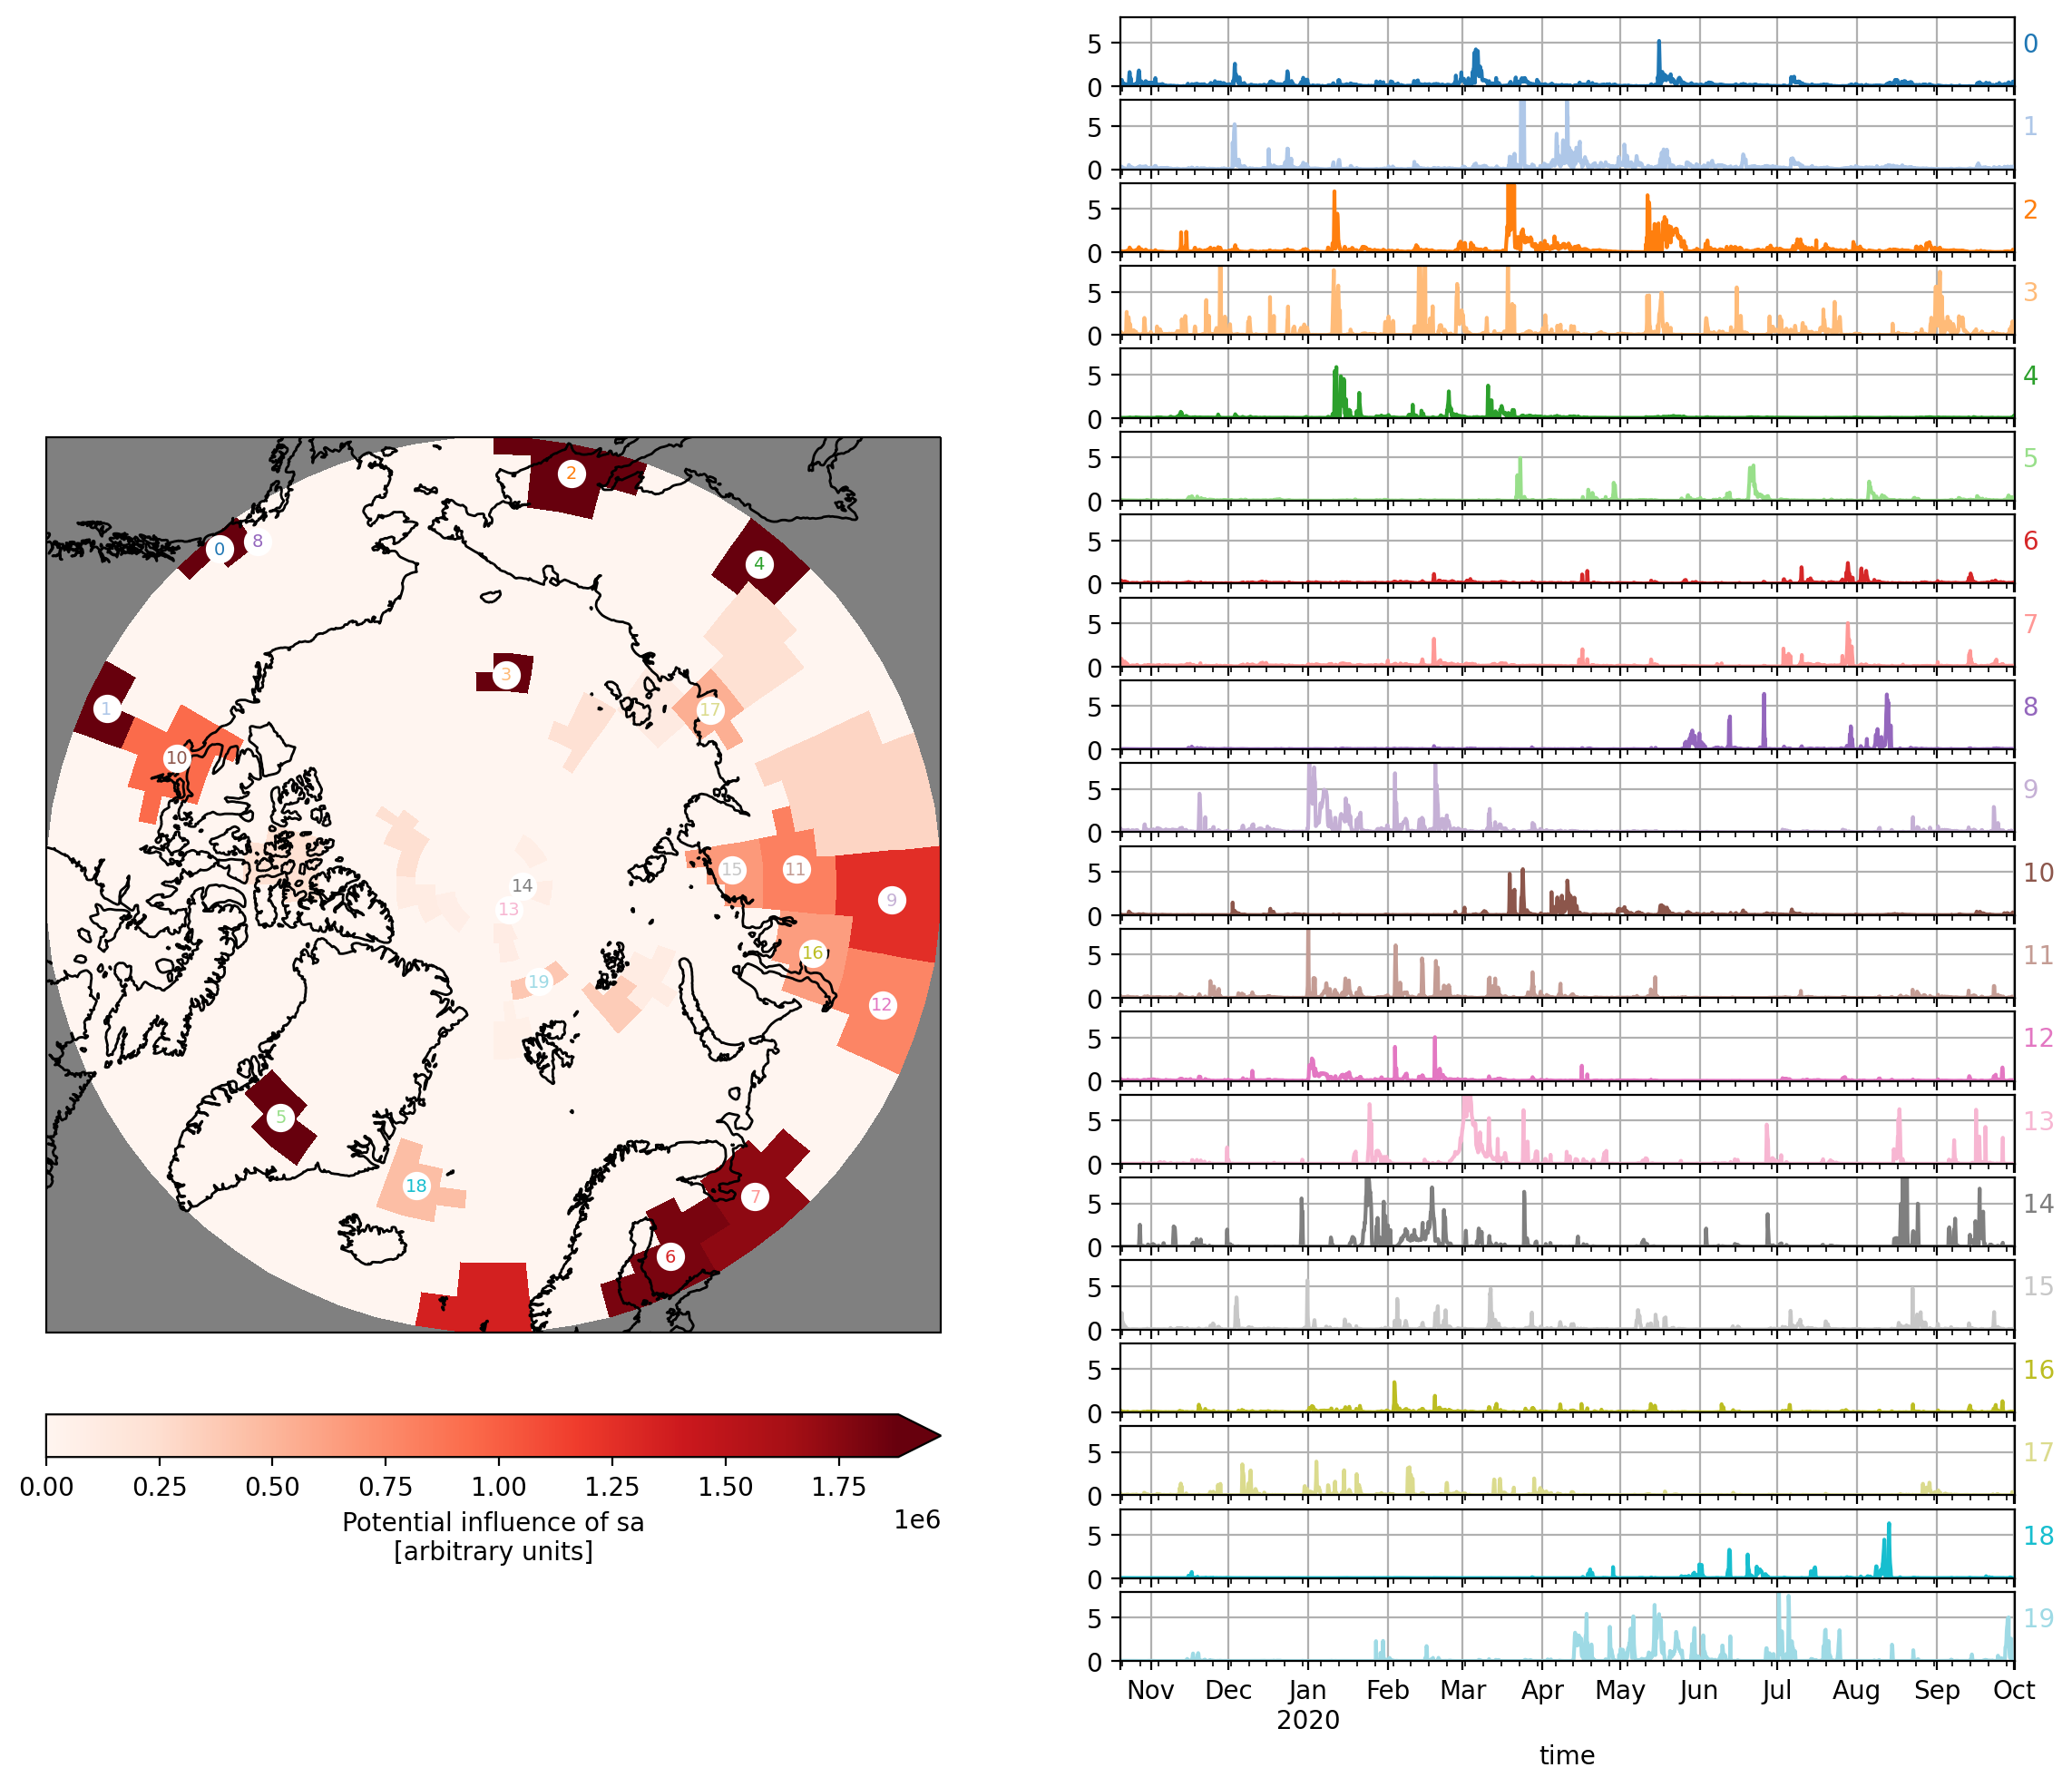

In [29]:
lco = len(co)

f = plt.figure(constrained_layout=True,figsize=(2*7,lco*.6),dpi=200)

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(lco,2)




# f,axs=plt.subplots(lco,dpi=200,sharex=True,sharey=True,figsize=(7,lco*.6))


ax0 = None
for i,c in enumerate(co):
    ax = f.add_subplot(gs[i, 1],sharex=ax0)
    if i == 0: ax0 = ax
    (dm2[c]).plot(c=cmap(i),ax=ax)
    ax.text(1,.5,f' {i}',transform=ax.transAxes,c=cmap(i))
    ax.grid()
    ax.set_ylim(0,q2*1.1)
# ax=plt.gca()
# ax.set_yscale('log')
# ax.set_ylim(q1,q2)
# ax.legend(bbox_to_anchor=(1,1))


import cartopy.crs as ccrs
ax = f.add_subplot(gs[:,0],projection=ccrs.Orthographic(0, 90), facecolor="gray")
rfu.plot_map(dd2,ax=ax)
# ax=plt.gca()
for i,c in enumerate(co):
    p =df3.centroid[c]
    ax.scatter( p.x,p.y,transform=ccrs.PlateCarree(),c='w',s=105,alpha=1,zorder=19)
    ax.text( p.x,p.y,i,transform=ccrs.PlateCarree(),c=cmap(i),va='center',ha='center',fontsize=7,zorder = 20)



In [30]:
    from sklearn.linear_model import ElasticNetCV,ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = dm[PAR]
    yn = y.notna()
    y = y[yn]
    ii = [.1, .5, .7, .9, .95, .99, 1]
    regr = ElasticNetCV(cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)
#     regr = ElasticNet( random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf / xn

In [31]:
regr = ElasticNetCV(alphas=.5,cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)

In [32]:
ccs = {}
r = {}
for a in np.geomspace(.1,8e3,201):
    from sklearn.linear_model import ElasticNetCV,ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = dm[PAR]
    yn = y.notna()
    y = y[yn]
    ii = [.1, .5, .7, .9, .95, .99, 1]
#     
    regr = ElasticNet(alpha=a, random_state=0, positive=True, l1_ratio=1, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf
    cdf = cdf/cdf.sum()
    ccs[a]=cdf
    r[a]=regr.score(XX[yn], y[yn])

In [33]:
regr = ElasticNetCV(cv=5, random_state=0, positive=True, l1_ratio=ii, fit_intercept=False)
regr.fit(XX[yn], y[yn])

ElasticNetCV(cv=5, fit_intercept=False,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], positive=True,
             random_state=0)

In [34]:
regr.alpha_

568.4891766138174

<AxesSubplot:>

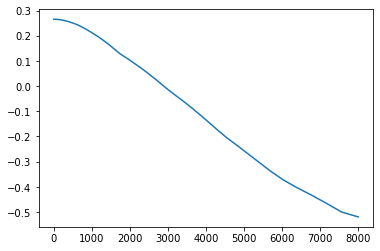

In [35]:
pd.Series(r).plot()

In [36]:
ddd = pd.DataFrame(ccs).T

In [37]:
ddd

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0.100000,0.0,0.0,0.019391,0.016957,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.071944,0.0,0.0,0.016957
0.105807,0.0,0.0,0.019391,0.016957,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.071944,0.0,0.0,0.016957
0.111952,0.0,0.0,0.019391,0.016957,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.071944,0.0,0.0,0.016957
0.118453,0.0,0.0,0.019391,0.016957,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.071944,0.0,0.0,0.016957
0.125332,0.0,0.0,0.019391,0.016957,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.071944,0.0,0.0,0.016957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383.049131,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.308210,0.0,0.0,0.000000
6753.729109,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.259039,0.0,0.0,0.000000
7145.935421,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.175055,0.0,0.0,0.000000
7560.918157,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [38]:
l = []
for a,r in ddd.iloc[::-1].iloc[::].iterrows():
    
    rr = r[~r.index.isin(l)]

    try:
        iii = rr.idxmax()
    #     print(iii)
        if rr.sum() == 0:
            continue
#             print(a)
        l.append(iii)
    except:
        break
    
    

In [39]:
len(l)

46

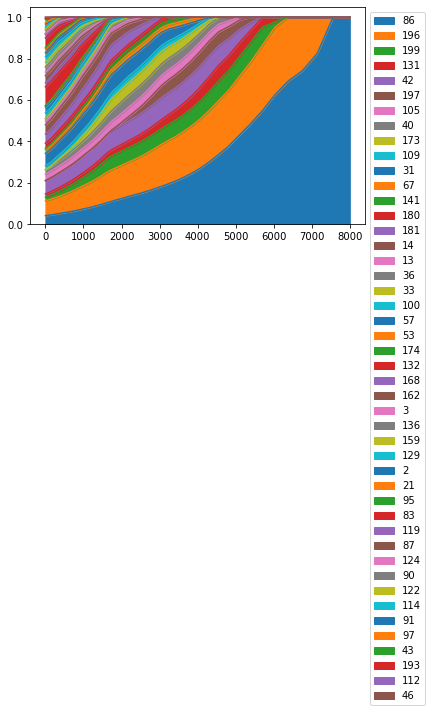

In [40]:
ddd[l].plot.area()
ax = plt.gca()
ax.legend(bbox_to_anchor=(1,1))
# ax.legend().remove()

In [41]:
rem = set(ddd.columns)-set(l)
l1 = [*l,*rem]

In [42]:
dd = pd.Series(l1).reset_index().set_index(0)['index'].to_dict()

In [43]:
ds2 = ds[L].to_series().replace(dd).to_xarray()

In [44]:
ds

<xarray.Dataset>
Dimensions:    (lon: 72, lat: 24, time: 3021)
Coordinates:
  * lon        (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat        (lat) float64 60.62 61.88 63.12 64.38 ... 85.62 86.88 88.12 89.38
  * time       (time) datetime64[ns] 2019-09-20T09:00:00 ... 2020-10-01T21:00:00
    lab        (lat, lon) int64 162 193 193 173 173 173 ... 123 123 123 123 144
Data variables:
    AIRTRACER  (time, lat, lon) float32 0.0004269 0.0001852 ... 0.0002132

In [45]:
q1,q2 = ds[AT].sum('time').quantile([.01,.5])

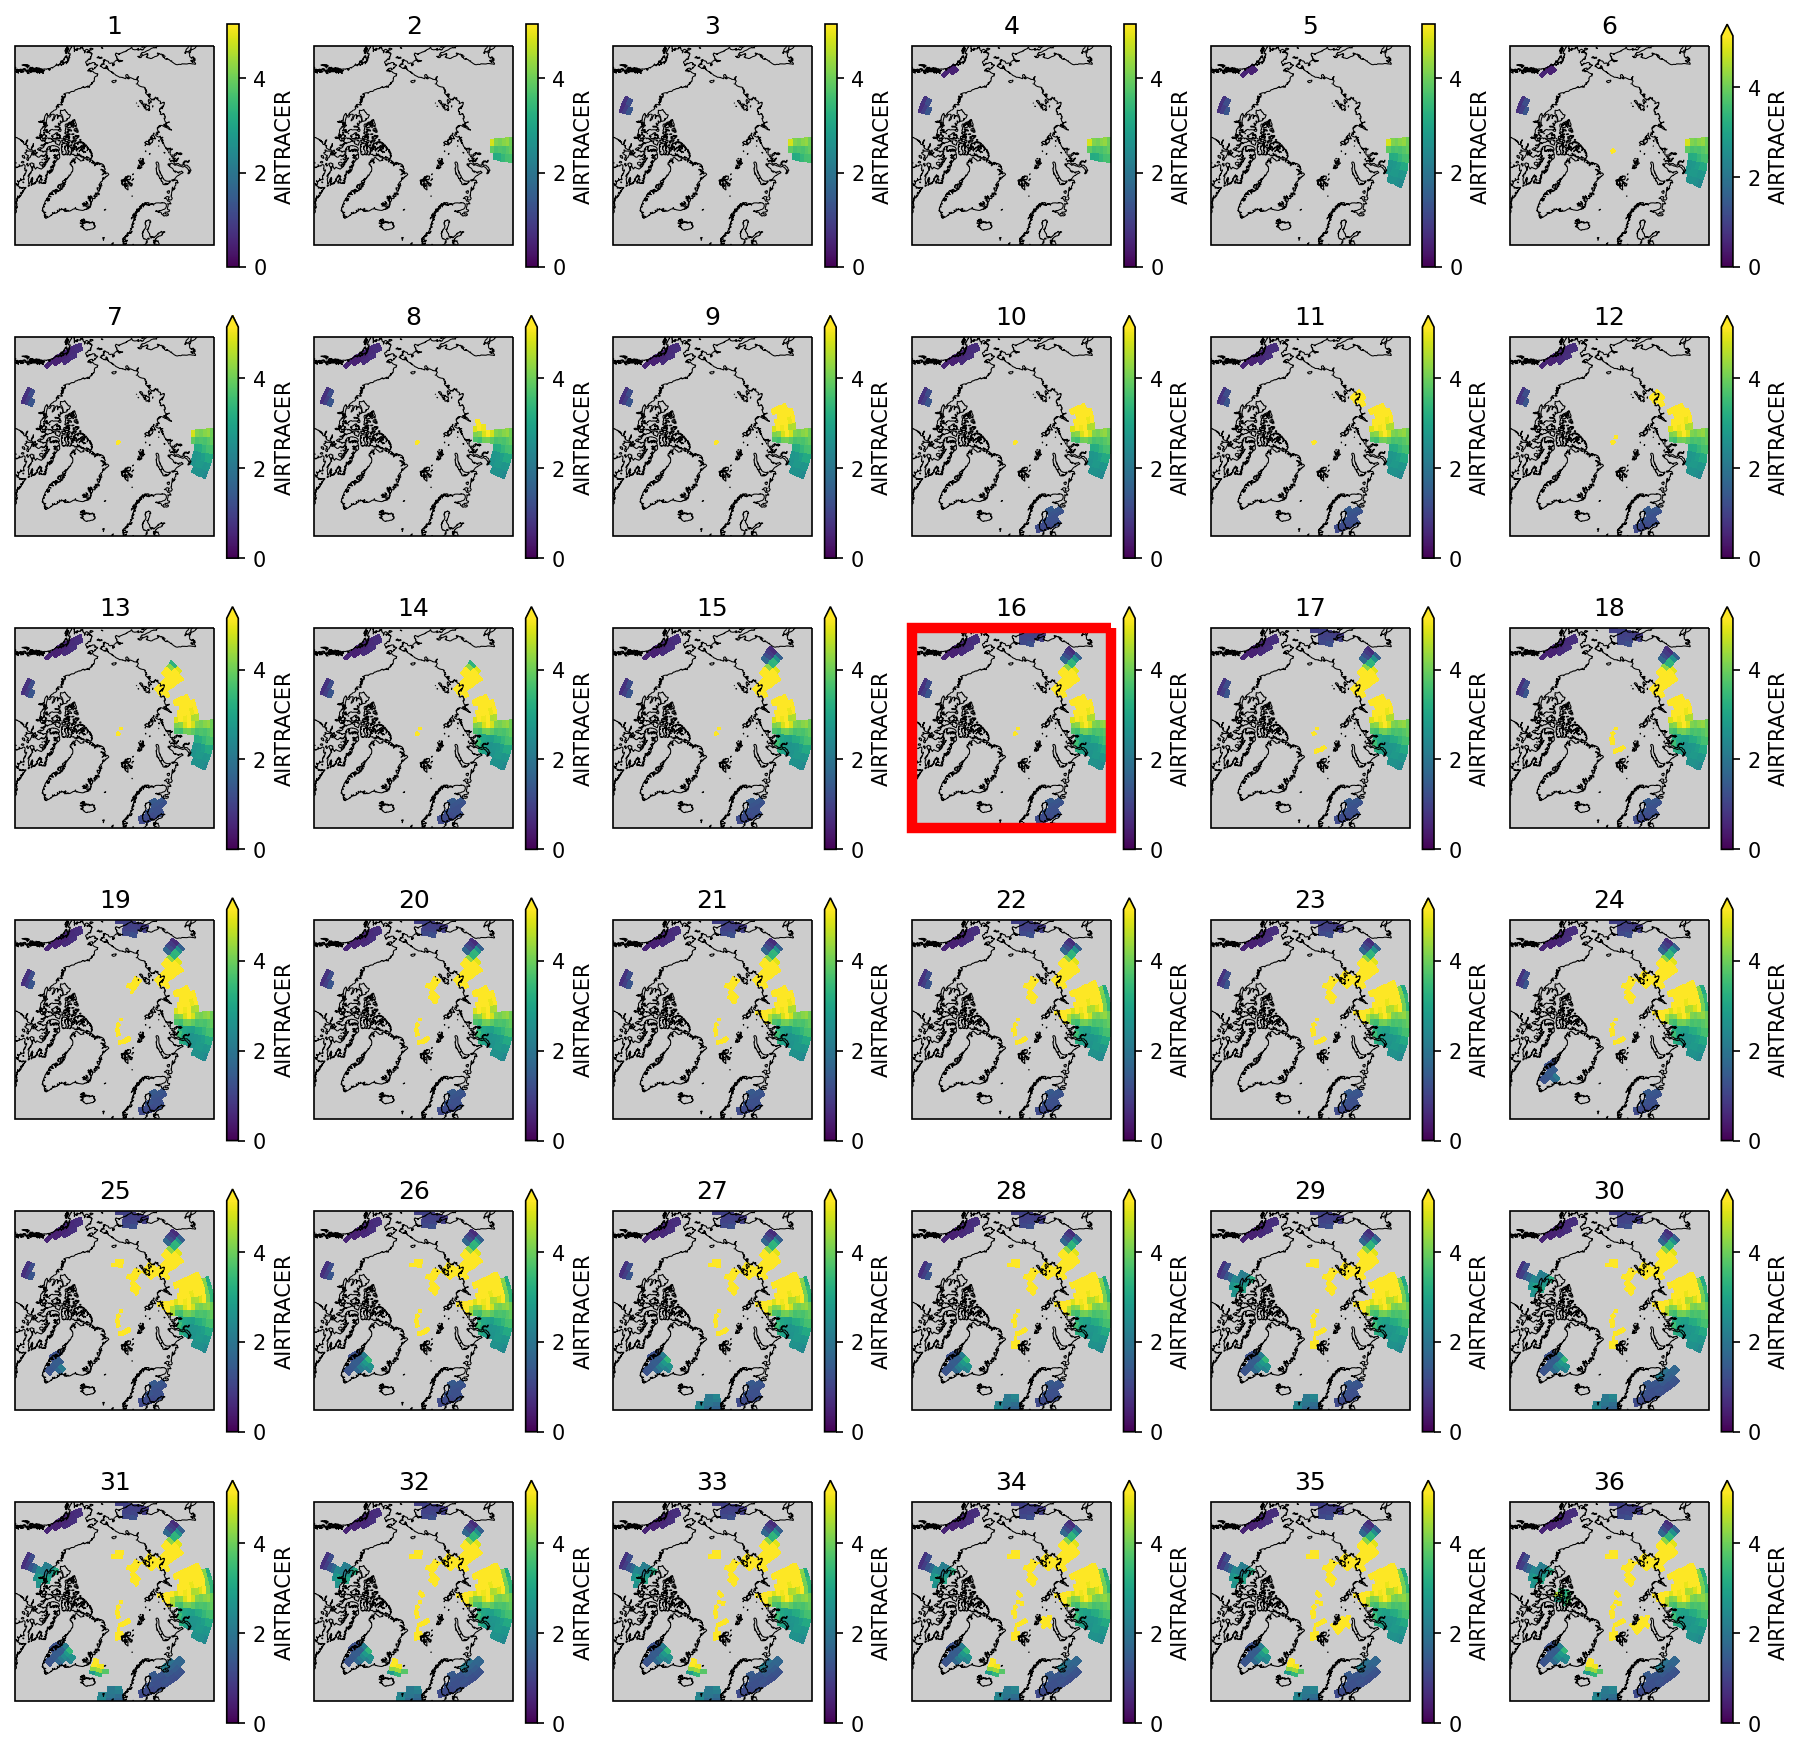

In [176]:
import matplotlib as mpl
dic = dict(projection=ccrs.Orthographic(0, 90), facecolor=".8")


f, axs = plt.subplots(6,6,subplot_kw=dic, sharex=True,sharey=True,figsize=(15,15),dpi=150)
for i in range(36):
    ax = axs.flatten()[i]
    p=ds[AT].sum('time').where(ds2<i).plot(
        # subplot_kws=dic,
        transform=ccrs.PlateCarree(),
    #     norm=mpl.colors.LogNorm(vmin, vmax),
    #     robust=True,
        cmap='viridis',
        vmax=q2,
        vmin=0,
        ax=ax
        
    )
    ax.set_title(i+1)
    if i ==15:    
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(5)
    p.axes.coastlines(lw=.5)



In [47]:
ds16 = ds[AT].sum('time').where(ds2<i)

In [48]:
ds16.to_dataframe()

lab  AIRTRACER
lat    lon                  
60.625 2.5    162        NaN
       7.5    193        NaN
       12.5   193        NaN
       17.5   173   1.107274
       22.5   173   1.101493
...           ...        ...
89.375 337.5  123        NaN
       342.5  123        NaN
       347.5  123        NaN
       352.5  123        NaN
       357.5  144        NaN

[1728 rows x 2 columns]

In [49]:
import geopandas

d5 = fu.get_bounds(LA, ds[AT])
d6 = fu.get_bounds(LO, d5)

df = d6[L].to_dataframe()

df1 = df.loc[:, ~df.columns.duplicated()]

G = 'geometry'

df1[G] = df.apply(fu.get_pol, axis=1)


dg = geopandas.GeoDataFrame(df1).reset_index()

dg1 = dg[[L, G]].dissolve(by=L)

<AxesSubplot:>

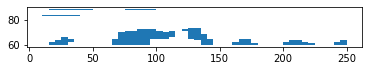

In [50]:
dg2=dg1[dg1.index.isin(l[:16])]
dg2.plot()

In [51]:
mpol = dg2.unary_union

In [52]:
pols = list(mpol)

In [169]:
pols_se = geopandas.GeoDataFrame(geometry=pols)

In [170]:
pols_se = pols_se[:]

In [171]:
pols_se['area'] = pols_se.area

In [172]:
ps1 = pols_se.sort_values('area')[::-1].reset_index(drop=True)

In [173]:
from shapely import geometry
ps1.contains(geometry.Point([.1,.1]))

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
dtype: bool

In [174]:
df= ds.to_dataframe()

In [175]:
iv = {}
for i,v in dg2.centroid.items():
    n = ps1[ps1.contains(v)].index[0]
    iv[i]=n

In [60]:
iv

{14: 6,
 31: 7,
 40: 0,
 42: 5,
 67: 1,
 86: 0,
 105: 0,
 109: 1,
 131: 0,
 141: 0,
 173: 2,
 180: 1,
 181: 3,
 196: 8,
 197: 4,
 199: 4}

In [61]:
dss =ds.to_dataframe()

In [177]:
dss

lab  AIRTRACER
lon   lat    time                               
2.5   60.625 2019-09-20 09:00:00  162   0.000427
             2019-09-20 12:00:00  162   0.000354
             2019-09-20 15:00:00  162   0.000287
             2019-09-20 18:00:00  162   0.000290
             2019-09-20 21:00:00  162   0.000438
...                               ...        ...
357.5 89.375 2020-10-01 09:00:00  144   0.000007
             2020-10-01 12:00:00  144   0.000006
             2020-10-01 15:00:00  144   0.000010
             2020-10-01 18:00:00  144   0.000009
             2020-10-01 21:00:00  144   0.000213

[5220288 rows x 2 columns]

In [62]:
dss1 = dss[dss[L].isin(l[:16])].copy()

In [63]:

NL = 'nl'

In [178]:
dss1[NL] = dss1[L].replace(iv)

In [197]:
dss2 = dss1.where(dss1[NL]<9)

In [198]:
ndf = dss2.reset_index().groupby([NL,'time'])[AT].sum().unstack().T

In [199]:
ndf

nl,0,1,2,3,4,5,6,7,8
time,,,,,,,,,
2019-09-20 09:00:00,0.011834,0.024645,0.001831,0.008871,0.003009,0.073558,0.000145,0.000063,0.000231
2019-09-20 12:00:00,0.012736,0.024684,0.001938,0.012416,0.003316,0.028905,0.000179,0.000036,0.000300
2019-09-20 15:00:00,0.012373,0.023693,0.001589,0.017557,0.003991,0.017514,0.000382,0.000040,0.000306
2019-09-20 18:00:00,0.011654,0.022704,0.001559,0.021219,0.003205,0.027635,0.001070,0.000045,0.000251
2019-09-20 21:00:00,0.012142,0.023355,0.002777,0.011202,0.002208,0.047274,0.005559,0.001747,0.000155
...,...,...,...,...,...,...,...,...,...
2020-10-01 09:00:00,0.108579,0.160427,0.004602,0.000598,0.001954,0.000216,0.001336,0.000259,0.000592
2020-10-01 12:00:00,0.132392,0.149509,0.003492,0.000395,0.001572,0.000157,0.001005,0.000245,0.000559
2020-10-01 15:00:00,0.104913,0.129562,0.004683,0.000345,0.001362,0.000236,0.001572,0.000288,0.000635


<AxesSubplot:xlabel='time'>

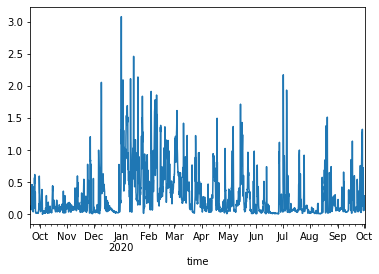

In [200]:
dss1.reset_index().groupby([NL,'time'])[AT].sum().unstack().sum().plot()

In [201]:
ndf.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='nl')

In [202]:
ndm = ndf.copy()

In [203]:
ndm[SA]=dm[SA]

In [204]:
PAR = SA

In [205]:
    from sklearn.linear_model import ElasticNetCV,ElasticNet, LinearRegression

    c200 = ndf.columns

    X = ndm[c200]

    xn = np.sqrt((X ** 2).sum())

    XX = X.divide(xn, axis=1)


    y = ndm[PAR]
    yn = y.notna()
    y = y[yn]
    ii = [.1, .5, .7, .9, .95, .99, 1]
#     
    regr = LinearRegression( positive=True, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = cdf
#     cdf = cdf/cdf.sum()

    r2=regr.score(XX[yn], y[yn])

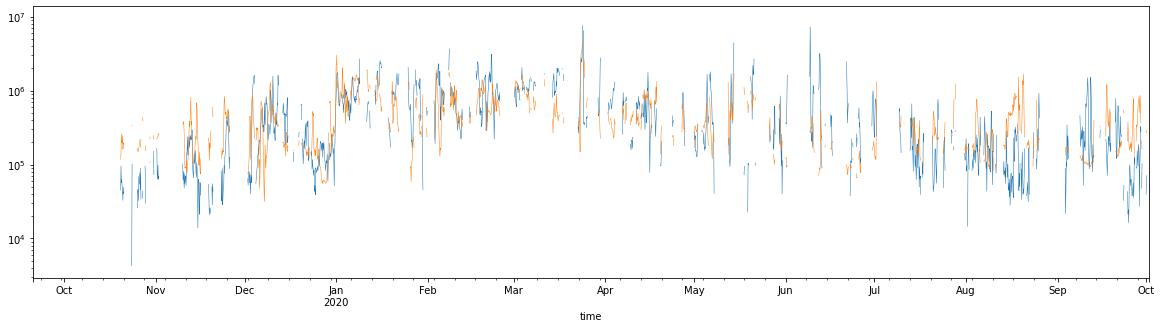

In [206]:
f,ax=plt.subplots(figsize=(20,5))
mod_ = (ndf/xn * cdf).sum(axis=1).where(yn)
ndm[SA].where(yn).plot(label=f"{SA} measured",lw=.5)
mod_.plot(label=f"{SA} inverse modeled",lw=.5)
plt.gca().set_yscale('log')

In [207]:
dum = pd.DataFrame()
dum['mea'] = ndm[SA].where(yn)
dum['mod'] = mod_

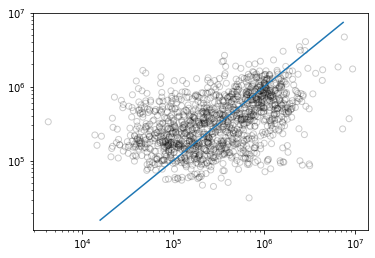

In [208]:
plt.scatter(dum['mea'],dum['mod'],alpha=.2, edgecolor='k', facecolor='none', )
ax= plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

q0, q1 = np.quantile([*dum[yn]['mea'].values,*dum[yn]['mod'].values], [.001, .999])

ax.plot(
    [q0, q1],
    [q0, q1],
    label=('1 to 1')
)

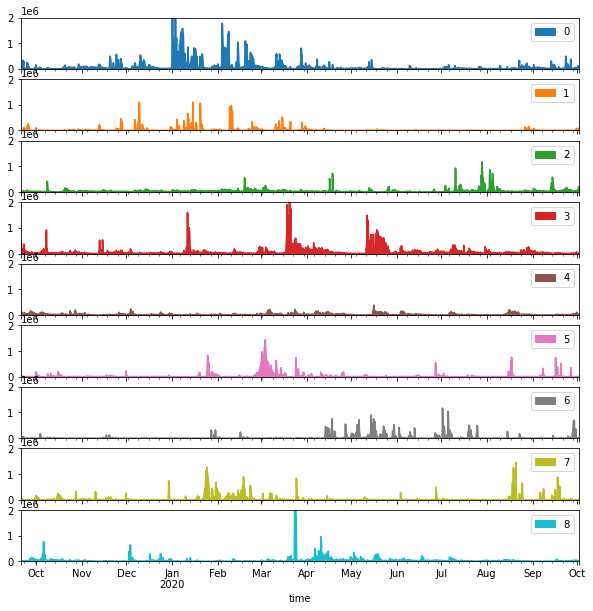

In [213]:
eight_=(ndf/xn * cdf)
eight_.plot.area(figsize=(10,10),subplots=True,sharey=True,ylim=(0,2.e6),cmap='tab10')
ax = plt.gca()


<AxesSubplot:>

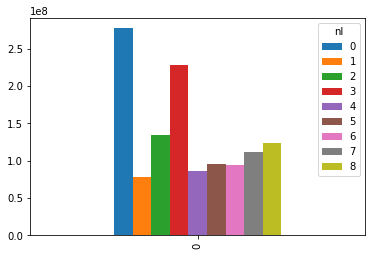

In [241]:
eight_.sum().to_frame().T.plot.bar()

<AxesSubplot:xlabel='nl'>

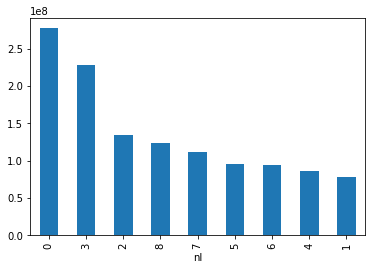

In [227]:
order = eight_.sum().sort_values()[::-1]
order.plot.bar()

In [214]:
eight_.to_csv('../data_out/eight_sa_sources_inverse.csv')

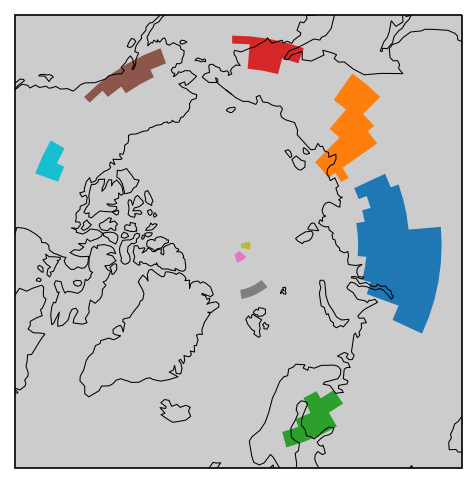

In [228]:
dic = dict(projection=ccrs.Orthographic(0, 90), facecolor=".8")
f, ax = plt.subplots(subplot_kw=dic, sharex=True,sharey=True,dpi=150)
ps1.reset_index().plot(column='index',cmap='tab10',ax=ax,transform=ccrs.PlateCarree())
ax.coastlines(lw=.5)

(0.0, 90.0)

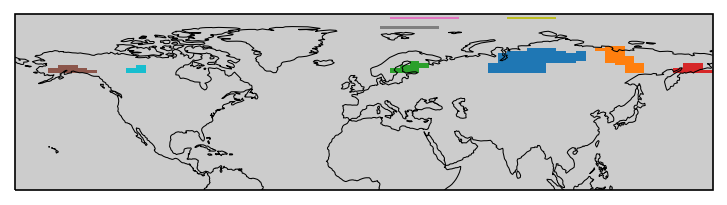

In [217]:
dic = dict(projection=ccrs.PlateCarree(), facecolor=".8")
f, ax = plt.subplots(subplot_kw=dic, sharex=True,sharey=True,dpi=150)
ps1.reset_index().plot(column='index',cmap='tab10',ax=ax,transform=ccrs.PlateCarree())
ax.coastlines(lw=.5)
ax.set_ylim(0,90)

In [137]:
dss1.to_xarray()[AT][{'time':2}]

<xarray.DataArray 'AIRTRACER' (lon: 34, lat: 13)>
array([[4.14232018e-05,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [3.99644669e-05, 1.08371722e-04, 1.36693372e-04, 1.17103867e-02,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [4.89869562e-05, 1.13848124e-04, 1.18038901e-04, 3.63063999e-03,
        1.03157370e-04,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [6.44159518e-05, 1.17111129e-04, 1.23705991e-04, 1.36835128e-03,
        1.27007006e-04, 1.27462859e-04, 1.38275776e-04,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [8.02495124e-05,            nan,            nan, 5.24809642e-04,
        1.68134866e-04, 2.07272489e-04,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
...
       [           nan, 4.44617268e-04, 4.79671668e-04,            nan,
        3.22474167e-04,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan, 1.36048431e-04, 1.55414775e-04,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan, 3.25627479e-05,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan, 7.15211718e-05, 8.47575720e-05,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan],
       [           nan, 3.45716035e-05, 6.31191433e-05,            nan,
        5.15876127e-05,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 12.5 17.5 22.5 27.5 32.5 ... 217.5 222.5 242.5 247.5
  * lat      (lat) float64 83.12 60.62 61.88 88.12 ... 69.38 70.62 71.88 73.12
    time     datetime64[ns] 2019-09-20T15:00:00

In [215]:
#convert to mrakdown
!jupyter-nbconvert --to markdown z030_inverse_modeling_time_series.ipynb

[NbConvertApp] Converting notebook z030_inverse_modeling_time_series.ipynb to markdown
[NbConvertApp] Support files will be in z030_inverse_modeling_time_series_files/
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inverse_modeling_time_series_files
[NbConvertApp] Making directory z030_inv